In [1]:
using Plots, LinearAlgebra, Random
using RandomMatrices, ProgressBars, MatrixEquations
using Convex, SCS, JLD, Gurobi
using MathOptInterface, JuMP
using Mosek, MosekTools
const MOI = MathOptInterface
using KernelEstimator
# const env = Gurobi.Env()

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/home/patrik/.julia/packages/Plots/vsE7b/src/backends/hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f4ac814758f, Ptr{Nothing} @0x00007f4ac81d7ebc, Ptr{Nothing} @0x00007f4ac81d8405, Ptr{Nothing} @0x00007f4ac81d806f, Ptr{Nothing} @0x00007f4ac81d8a73, Ptr{Nothing} @0x00007f4ac81d9cd7, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00007f4ac81f6ee9, Ptr{Nothing} @0x00007f4ac81f7662, Ptr{Nothing} @0x00007f4ac81f6a4a, Ptr{Nothing} @0x00007f4ac81f69e9, Ptr{Nothing} @0x00007f4ac81c9735, Ptr{Nothing} @0x00007f4ac81f8491, Ptr{Nothing} @0x00007f4aba3d0575, Ptr{Nothing} @0x00007f4a95f2e1de, Ptr{Nothing} @0x00007f4ac81bec57, Ptr{Nothing} @0x00007f4ac81d8425, Ptr{Nothing} @0x00007f4ac81d806f, Ptr{Nothing} @0x00007f4ac81d8a73, Ptr{Nothing} @0x00007f4ac81d9cd7, Base.InterpreterIP in top-level CodeInfo for Plots at 

In [2]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Algos.ipynb")

barycenter_functional (generic function with 1 method)

# Generating data

### Setting parameters

In [291]:
n = 30
d = 40

α = 0.005
β = 200
κ = β/α
mult = 4
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n);

### data generation

In [292]:
# generate1(covs, sqrt_covs, α, β)
# generate2(covs, sqrt_covs, κ)
# generate3(covs, sqrt_covs, α, β)
# generate4(covs, sqrt_covs, α, β, mult)
generate1234(covs, sqrt_covs, α, β, κ, mult)
# save("./data/n$(n)d$(d)a$(α)b$(β).jld", "covs", covs, "sqrt_covs", sqrt_covs)

thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2

for i in 1:n
    if minimum(eigvals(covs[:,:,i])) <= 0 || covs[:,:,i] != covs[:,:,i]'
        println("Something's wrong")
    end
end

In [297]:
nIter = 10
XX = covs[:,:,1]
obj = zeros(nIter)
times = zeros(nIter)

GD!(nIter, covs, sqrt_covs, XX, obj, times, 1)

In [299]:
obj[end] - barycenter_functional(sqrt_covs, X)

-5.587935447692871e-9

In [294]:
nIter = 100
X = covs[:,:,1]
obj = zeros(nIter)
times = zeros(nIter)

EGD!(nIter, covs, sqrt_covs, X, obj, times, 10000, thresh_a, thresh_b)

In [256]:
thresh_b/thresh_a

36.88037645896342

### load dataset

In [6]:
# loaded = load("./data/n$(n)d$(d)a$(α)b$(β).jld")
# covs .= loaded["covs"]
# sqrt_covs .= loaded["sqrt_covs"];

# Comparing the speed of algos

In [90]:
nIter = 30
nExp = 30
n = 5
d = 5
α = 0.005
β = 200
κ = β/α
mult = 4
η_gd = 1
η₁ = 100000
η₂ = 180000
η₃ = 30000
data_generation_method = 5

covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
# SDP=5
######################

# Set up arrays
X = zeros(d,d, 4)
X_SDP = zeros(d,d, nIter)
times = zeros(5, nExp, nIter)
objective = zeros(5, nExp, nIter)
optimal_objective = zeros(nExp)

for experiment in 1:nExp
    # Generate new dataset
    if data_generation_method==1
        generate1(covs, sqrt_covs, α, β)
    elseif data_generation_method==2
        generate2(covs, sqrt_covs, κ)
    elseif data_generation_method==3
        generate3(covs, sqrt_covs, α, β)
    elseif data_generation_method==4
        generate4(covs, sqrt_covs, α, β, mult)
    else
        generate1234(covs, sqrt_covs, α, β, κ, mult)
    end
    
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    
    # Compute high precision solution to compare to
    solution = covs[:,:,1]
    GD!(2*nIter, covs, sqrt_covs, solution, zeros(2*nIter), zeros(2*nIter), 1)
    optimal_objective[experiment] = barycenter_functional(sqrt_covs, solution)
    
    # Set up SDP model
    Σ = Variable(d,d)
    Ss = [Variable(d,d) for _ in 1:n]
    constr = [([covs[:,:,i] Ss[i]; Ss[i]' Σ] ⪰ 0) for i in 1:n]
    problem = minimize(tr(Σ) - 2*mean(tr.(Ss)))
    problem.constraints += constr
    problem.constraints += (Σ ⪰ 0)
    
    # Set starting points to be second step of SDP (so everyone starts from same point)
    start = time()
    solve!(problem, SCS.Optimizer(verbose = false, max_iters = 2))
    time_adjust = time() - start

    for i in 1:nIter
        X_SDP[:,:,i] .= Σ.value
    end

    X[:,:, 1] .= Σ.value
    X[:,:, 2] .= Σ.value 
    X[:,:, 3] .= Σ.value
    X[:,:, 4] .= Σ.value
    
    set_value!(Σ, covs[:,:,1])

    tmp_obj = @view objective[1, experiment, :]
    tmp_times = @view times[1, experiment, :]
    tmp_X = @view X[:, :, 1]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₁, thresh_a, thresh_b)

    tmp_obj = @view objective[2, experiment, :]
    tmp_times = @view times[2, experiment, :]
    tmp_X = @view X[:, :, 2]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₂, thresh_a, thresh_b)

    tmp_obj = @view objective[3, experiment, :]
    tmp_times = @view times[3, experiment, :]
    tmp_X = @view X[:,:, 3]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₃, thresh_a, thresh_b)

    tmp_obj = @view objective[4, experiment, :]
    tmp_times = @view times[4, experiment, :]
    tmp_X = @view X[:, :, 4]
    GD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η_gd)

    for i in 2:nIter
        start = time()
        solve!(problem, SCS.Optimizer(verbose = false, max_iters = i+1))
        times[5, experiment, i] = time()-start
        X_SDP[:,:,i] .= Σ.value
    end
    objective[5,experiment, :] .= barycenter_functional(sqrt_covs, covs[:,:,1])
#     objective[5,experiment, :] = real.([barycenter_functional(sqrt_covs, X_SDP[:,:,i]) for i in 1:nIter]);
    
    
    # recenter so that timeseries starts at t=0
    times[1,experiment, :] .= times[1,experiment, :] .- times[1,experiment, 1]
    times[2,experiment, :] .= times[2,experiment, :] .- times[2,experiment, 1]
    times[3,experiment, :] .= times[3,experiment, :] .- times[3,experiment, 1]
    times[4,experiment, :] .= times[4,experiment, :] .- times[4,experiment, 1]
#     times[5,experiment, 2:end] .= max.(0, times[5,experiment, 2:end] .- time_adjust)
end

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solutio

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253

In [91]:
log_objective = log.(max.(objective .- optimal_objective', sqrt(eps())))
collated = zeros(5, nIter*nExp, 2)
for algo in 1:5
    collated[algo, :, :] = [reshape(times[algo, :, :], (nIter*nExp,)) reshape(log_objective[algo, :, :], (nIter*nExp,))]
    
    collated[algo, :, :] .= sortslices(collated[algo, :, :], dims=1, lt=(x,y)->isless(x[1],y[1]))
end

smoothed = zeros(5, nIter*nExp)
for algo in 1:5
    smoothed[algo, :] = KernelEstimator.npr(collated[algo, :, 1], collated[algo, :, 2], kernel=gaussiankernel, reg=localconstant)
end

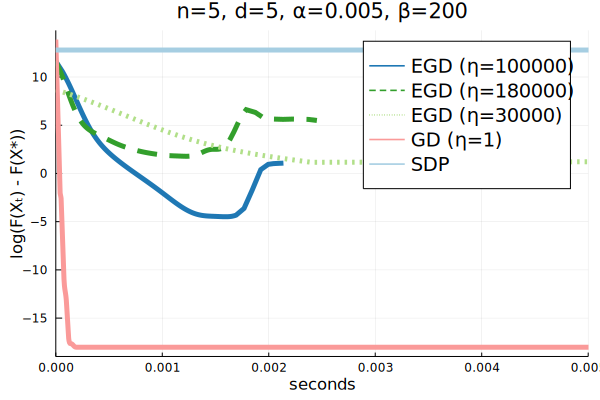

In [92]:
plot(collated[:,:,1]', smoothed', 
    linestyles = [:solid :dash :dot :solid :solid], 
    linecolors = [2 4 3 5 1], 
    linewidth = 5, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"], 
    legend=:topright, 
    legendfontsize=13, 
    color_palette=palette(:Paired_5, 5), 
    fontfamily = "New Century Schoolbook Roman")
title!("n=$(n), d=$(d), α=$(α), β=$(β)")
ylabel!("log(F(Xₜ) - F(X*))")
xlabel!("seconds")
xlims!(0,0.005)
# ylims!(3.4,4.2)

# Dependence on condition number

### Generate random dataset

In [94]:
n = 100
d = 10
mult = 4

covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

nIter = 40
η_gd = 1
η₁ = 100
η₂ = 180
η₃ = 300

######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
######################

# values of κ to compare
κs = LinRange(2,100000,10)

# Set up arrays
X = zeros(d, d)
objective = zeros(nIter, length(κs), 4)
times = zeros(nIter, length(κs), 4)
best = zeros(length(κs))
data_generation_method=1

for i in 1:length(κs)
    κ = κs[i]
    α = 1/sqrt(κ)
    β = sqrt(κ)
    # Generate new dataset
    if data_generation_method==1
        generate1(covs, sqrt_covs, α, β)
    elseif data_generation_method==2
        generate2(covs, sqrt_covs, κ)
    elseif data_generation_method==3
        generate3(covs, sqrt_covs, α, β)
    elseif data_generation_method==4
        generate4(covs, sqrt_covs, α, β, mult)
    else
        generate1234(covs, sqrt_covs, α, β, κ, mult)
    end

    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 1]
    times_tmp = @view times[:,i, 1]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₁, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 2]
    times_tmp = @view times[:,i, 2]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₂, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 3]
    times_tmp = @view times[:,i, 3]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₃, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 4]
    times_tmp = @view times[:,i, 4]
    GD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η_gd)
    
    # Set output of GD! as benchmark   
    best[i] = minimum(objective[:,i,:])
end

In [95]:
ϵ = -10
first_index = Array{Int64}(undef, (length(κs), 4))
for model in 1:4
    arr = log10.(objective[:, :, model] .- best')
    for κ in 1:length(κs)
        first_index[κ, model] = nIter
        done=false
        for j in 1:nIter
            if arr[j,κ] < ϵ
                done = true
                first_index[κ, model] = min(first_index[κ, model], j)
            end
        end
        if !done
            first_index[κ, model] = 1000
        end
    end
end

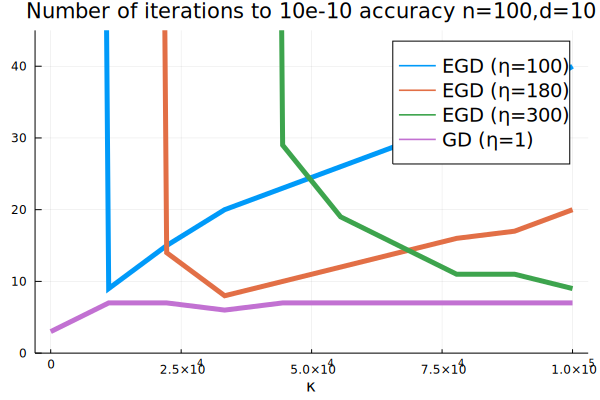

In [96]:
plot(κs, first_index, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"],
    legend=:topright,
    legendfontsize=13,
    linewidth = 5, 
    fontfamily = "New Century Schoolbook Roman")
title!("Number of iterations to 10e$(ϵ) accuracy n=$(n),d=$(d)")
ylims!(0,45)
xlabel!("κ")

# Dependence on dimension

In [100]:
# Number of matrices
n = 30
α = 0.1
β = 10


nIter = 10
η_gd = 1
η₁ = 8
η₂ = 9
η₃ = 10
data_generation_method = 1
mult = 4


######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
######################

# values of κ to compare
ds = [2,3,5,10,20,30,40,50,70,90,100,130,150,180, 200, 500]

# Set up arrays
objective = zeros(nIter, length(ds), 4)
times = zeros(nIter, length(ds), 4)
best = zeros(length(ds))

for i in 1:length(ds)
    d = ds[i]
    
    # covs contains the covariance matrices whose barycenter we are trying to find
    covs = zeros(d,d,n)
    # sq_covs contains the square roots of the matrices in covs
    sqrt_covs = zeros(d,d,n)
    
    X = zeros(d, d)

    # Generate new dataset
    if data_generation_method==1
        generate1(covs, sqrt_covs, α, β)
    elseif data_generation_method==2
        generate2(covs, sqrt_covs, κ)
    elseif data_generation_method==3
        generate3(covs, sqrt_covs, α, β)
    elseif data_generation_method==4
        generate4(covs, sqrt_covs, α, β, mult)
    else
        generate1234(covs, sqrt_covs, α, β, κ, mult)
    end

    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 1]
    times_tmp = @view times[:,i, 1]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₁, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 2]
    times_tmp = @view times[:,i, 2]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₂, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 3]
    times_tmp = @view times[:,i, 3]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₃, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 4]
    times_tmp = @view times[:,i, 4]
    GD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η_gd)
    
    # Set output of GD! as benchmark   
    best[i] = minimum(objective[:,i,:])
end

In [101]:
ϵ = -7
first_index = Array{Int64}(undef, (length(ds), 4))
for model in 1:4
    arr = log10.(objective[:, :, model] .- best')
    for d in 1:length(ds)
        first_index[d, model] = nIter
        done=false
        for j in 1:nIter
            if arr[j,d] < ϵ
                done = true
                first_index[d, model] = min(first_index[d, model], j)
            end
        end
        if !done
            first_index[d, model] = 1000
        end
    end
end

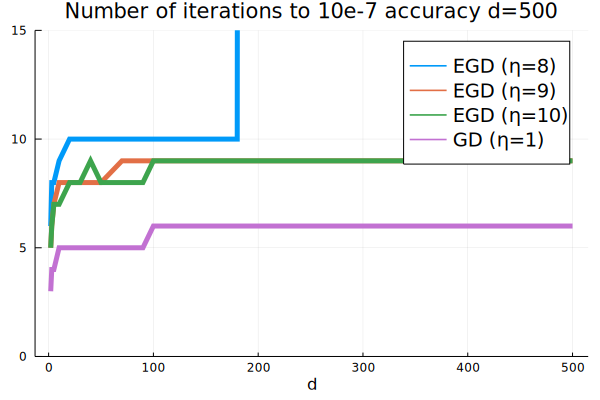

In [105]:
plot(ds, first_index, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"], 
    legend=:topright,
    legendfontsize=13,
    linewidth = 5, 
    fontfamily = "New Century Schoolbook Roman")
title!("Number of iterations to 10e$(ϵ) accuracy d=$(d)")
ylims!(0,15)
xlabel!("d")

# Trying MOSEK instead of SCS (slower)


In [371]:
model = Model(Mosek.Optimizer)
@variable(model, Σ[1:d,1:d], PSD)
Ss = []
for i in 1:n
    push!(Ss, @variable(model, [1:d,1:d], Symmetric))
end

for i in 1:n
    @SDconstraint(model, [covs[:,:,i] Ss[i]; Ss[i]' Σ] >= 0)
#     @SDconstraint(model, Σ - Ss[i]*covs[:,:,i]^(-1)*Ss[i]' >= 0)
#     @constraint(model, Σ - Ss[i]*covs[:,:,i]^(-1)*Ss[i]' in PSDCone())
end
@objective(model, Min, tr(Σ)-2*mean(tr(Ss[i]) for i in 1:n));
@time optimize!(model)
value.(Σ)

1000-element LinRange{Float64}:
 2.0,12.008,22.016,32.024,42.032,52.04,…,9969.98,9979.98,9989.99,10000.0